# به نام خدا 

# فاز یک


In [63]:
import os
import cv2
import numpy as np
import pandas as pd
from skimage.feature import local_binary_pattern
from skimage.color import rgb2gray
from skimage.transform import resize

In [64]:


# تنظیمات مسیر و پارامترها
dataset_path = "train"
output_csv = "image_features_15.csv"
classes = ["beach", "dense_residential", "desert", "forest", "intersection", "sea_ice"]

# پارامترهای LBP
radius = 1
n_points = 8 * radius

def extract_features(image):
    # تغییر اندازه تصویر برای یکنواختی پردازش
    image = resize(image, (128, 128), anti_aliasing=True)
    
    R, G, B = image[:, :, 0], image[:, :, 1], image[:, :, 2]

    # ویژگی‌های رنگی
    mean_r, mean_g, mean_b = np.mean(R), np.mean(G), np.mean(B)
    var_r, var_g, var_b = np.var(R), np.var(G), np.var(B)
    std_r, std_g, std_b = np.std(R), np.std(G), np.std(B)
    ratio_rg = mean_r / (mean_g + 1e-5)
    ratio_gb = mean_g / (mean_b + 1e-5)
    ratio_rb = mean_r / (mean_b + 1e-5)

    # تبدیل به خاکستری برای ویژگی‌های بافت و روشنایی
    gray_image = rgb2gray(image)
    
    # ویژگی بافتی - LBP میانگین
    lbp = local_binary_pattern(gray_image, n_points, radius, method='uniform')
    lbp_mean = np.mean(lbp)
    
    # ویژگی لبه‌ای - میانگین شدت لبه‌ها با فیلتر Sobel
    sobel_x = cv2.Sobel((gray_image * 255).astype(np.uint8), cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel((gray_image * 255).astype(np.uint8), cv2.CV_64F, 0, 1, ksize=3)
    edge_magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
    edge_mean = np.mean(edge_magnitude)
    
    # ویژگی‌های آماری شدت خاکستری
    mean_gray = np.mean(gray_image)
    std_gray = np.std(gray_image)
    var_gray = np.var(gray_image)

    return [
        mean_r, mean_g, mean_b,
        var_r, var_g, var_b,
        std_r, std_g, std_b,
        ratio_rg, ratio_gb, ratio_rb,
        lbp_mean, edge_mean,
        mean_gray, std_gray, var_gray
    ]

def process_image(image_path):
    try:
        image = cv2.imread(image_path)
        if image is None:
            print(f"⚠️ خطا در خواندن تصویر: {image_path}")
            return None
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return extract_features(image)
    except Exception as e:
        print(f"❌ خطا در پردازش {image_path}: {str(e)}")
        return None

# پردازش دیتاست
data = []
for class_name in classes:
    class_path = os.path.join(dataset_path, class_name)
    if not os.path.exists(class_path):
        print(f"⚠️ پوشه {class_path} وجود ندارد!")
        continue
    for img_file in os.listdir(class_path):
        img_path = os.path.join(class_path, img_file)
        features = process_image(img_path)
        if features:
            data.append({
                "class": class_name,
                "filename": img_file,
                "mean_r": features[0],
                "mean_g": features[1],
                "mean_b": features[2],
                "var_r": features[3],
                "var_g": features[4],
                "var_b": features[5],
                "std_r": features[6],
                "std_g": features[7],
                "std_b": features[8],
                "ratio_rg": features[9],
                "ratio_gb": features[10],
                "ratio_rb": features[11],
                "lbp_mean": features[12],
                "edge_mean": features[13],
                "mean_gray": features[14],
                "std_gray": features[15],
                "var_gray": features[16],
            })

if data:
    df = pd.DataFrame(data)
    try:
        df.to_csv(output_csv, index=False)
        print(f"✅ {len(df)} تصویر پردازش شد و در '{output_csv}' ذخیره شد.")
    except PermissionError:
        print("❌ فایل باز است یا اجازه نوشتن نیست. آن را ببند یا مسیر را تغییر بده.")
else:
    print("❌ هیچ داده‌ای پردازش نشد!")


c:\Users\ZC4\AppData\Local\Programs\Python\Python313\Lib\site-packages\skimage\feature\texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


✅ 3600 تصویر پردازش شد و در 'image_features_15.csv' ذخیره شد.


# فاز دو

In [65]:
import pandas as pd
import numpy as np

In [66]:


# خواندن داده‌های فاز اول (۱۵ ویژگی)
df = pd.read_csv("image_features_15.csv")

# محاسبه همبستگی پیرسون بین دو ویژگی
def calculate_correlation(x, y):
    covariance = np.cov(x, y, bias=True)[0, 1]
    std_x = np.std(x)
    std_y = np.std(y)
    if std_x == 0 or std_y == 0:
        return 0  # جلوگیری از تقسیم بر صفر
    return covariance / (std_x * std_y)

# ایجاد ماتریس همبستگی برای تمام ویژگی‌های عددی
def create_correlation_matrix(features):
    feature_names = features.columns
    n = len(feature_names)
    corr_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            corr_matrix[i, j] = calculate_correlation(features.iloc[:, i], features.iloc[:, j])
    return corr_matrix, feature_names

# انتخاب ویژگی‌های با کمترین همبستگی متقابل
def select_optimal_features(corr_matrix, feature_names, n_features=5, threshold=0.7):
    selected = []
    remaining = list(feature_names)
    while len(selected) < n_features and remaining:
        avg_corrs = []
        for feat in remaining:
            idx = list(feature_names).index(feat)
            avg_corr = np.mean([
                abs(corr_matrix[idx][list(feature_names).index(f)]) for f in remaining if f != feat
            ])
            avg_corrs.append(avg_corr)
        best_idx = np.argmin(avg_corrs)
        best_feature = remaining.pop(best_idx)
        selected.append(best_feature)
        remaining = [
            f for f in remaining 
            if abs(corr_matrix[list(feature_names).index(best_feature)][list(feature_names).index(f)]) <= threshold
        ]
    return selected[:n_features]

# حذف ستون‌های غیر عددی
numeric_features = df.drop(columns=['class', 'filename'])

# محاسبه ماتریس همبستگی
corr_matrix, feature_names = create_correlation_matrix(numeric_features)

# چاپ ماتریس همبستگی به صورت جدول مرتب
print("\nماتریس همبستگی ویژگی‌ها:\n")
print(" " * 15 + " ".join([f"{name[:10]:>10}" for name in feature_names]))
for i, name in enumerate(feature_names):
    row = [f"{corr_matrix[i, j]:.2f}" for j in range(len(feature_names))]
    print(f"{name[:10]:>15} " + " ".join(row))

# انتخاب ویژگی‌ها (5 ویژگی)
optimal_features = select_optimal_features(corr_matrix, feature_names, n_features=5)

# ذخیره خروجی نهایی
selected_df = df[['class', 'filename'] + optimal_features]
selected_df.to_csv("selected_features_15.csv", index=False)

# چاپ ویژگی‌های انتخاب‌شده
print("\nویژگی‌های انتخاب‌شده برای فاز بعدی:")
for i, f in enumerate(optimal_features, 1):
    print(f"{i}. {f}")
print("\n📁 فایل خروجی: selected_features_15.csv ذخیره شد.")



ماتریس همبستگی ویژگی‌ها:

                   mean_r     mean_g     mean_b      var_r      var_g      var_b      std_r      std_g      std_b   ratio_rg   ratio_gb   ratio_rb   lbp_mean  edge_mean  mean_gray   std_gray   var_gray
         mean_r 1.00 0.97 0.89 -0.03 -0.11 -0.09 -0.10 -0.19 -0.16 0.73 0.14 0.67 -0.25 -0.25 0.98 -0.17 -0.09
         mean_g 0.97 1.00 0.96 0.08 -0.02 -0.01 0.00 -0.10 -0.07 0.56 0.08 0.50 -0.26 -0.22 1.00 -0.08 -0.00
         mean_b 0.89 0.96 1.00 0.21 0.13 0.15 0.16 0.07 0.10 0.49 -0.18 0.29 -0.31 -0.14 0.95 0.09 0.15
          var_r -0.03 0.08 0.21 1.00 0.93 0.88 0.96 0.91 0.87 -0.12 -0.42 -0.34 -0.23 0.44 0.06 0.92 0.95
          var_g -0.11 -0.02 0.13 0.93 1.00 0.97 0.92 0.97 0.94 -0.14 -0.46 -0.38 -0.20 0.56 -0.04 0.97 1.00
          var_b -0.09 -0.01 0.15 0.88 0.97 1.00 0.89 0.94 0.97 -0.11 -0.50 -0.39 -0.20 0.58 -0.02 0.94 0.97
          std_r -0.10 0.00 0.16 0.96 0.92 0.89 1.00 0.96 0.92 -0.14 -0.51 -0.41 -0.23 0.52 -0.01 0.97 0.94
          std_g -0

# فاز سه

In [79]:
import pandas as pd
import numpy as np
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, MeanShift
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors


In [88]:

# --- 1. بارگذاری داده‌ها (ویژگی‌های انتخاب شده ۱۵تایی) ---
try:
    data = pd.read_csv('selected_features_15.csv')
    features = data.drop(['class', 'filename'], axis=1)
except FileNotFoundError:
    print("❌ فایل 'selected_features_15.csv' پیدا نشد.")
    exit(1)
except Exception as e:
    print(f"❌ خطا در بارگذاری داده‌ها: {e}")
    exit(1)

# --- 2. نرمال‌سازی ویژگی‌ها ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# ذخیره scaler برای استفاده در فازهای بعدی
joblib.dump(scaler, 'scaler.joblib')

# --- 3. خوشه‌بندی ---

# الف) K-Means: جستجوی بهترین تعداد خوشه با silhouette score
print("\n--- خوشه‌بندی K-Means ---")
best_kmeans = None
best_score = -1
best_n_clusters = 0

for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10, max_iter=300, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    print(f"تعداد خوشه‌ها: {n_clusters}، silhouette score: {score:.4f}")
    if score > best_score:
        best_score = score
        best_kmeans = kmeans
        best_n_clusters = n_clusters

print(f"✅ بهترین تعداد خوشه‌ها برای K-Means: {best_n_clusters} با silhouette score = {best_score:.4f}")
data['kmeans_cluster'] = best_kmeans.labels_
joblib.dump(best_kmeans, 'best_kmeans_model.joblib')

# ب) DBSCAN
print("\n--- خوشه‌بندی DBSCAN ---")
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(X_scaled)
distances, indices = nbrs.kneighbors(X_scaled)
distances = np.sort(distances[:, 1], axis=0)

# شما می‌توانید eps را بر اساس نمودار elbow یا تجربه تغییر دهید
eps = 0.5
min_samples = 5

dbscan = DBSCAN(eps=eps, min_samples=min_samples)
dbscan_labels = dbscan.fit_predict(X_scaled)
data['dbscan_cluster'] = dbscan_labels
joblib.dump(dbscan, 'dbscan_model.joblib')

# ج) Agglomerative Clustering
print("\n--- خوشه‌بندی Agglomerative ---")
agg = AgglomerativeClustering(n_clusters=best_n_clusters, linkage='ward')
agg_labels = agg.fit_predict(X_scaled)
data['agg_cluster'] = agg_labels
joblib.dump(agg, 'agg_model.joblib')

# د) MeanShift
print("\n--- خوشه‌بندی MeanShift ---")
meanshift = MeanShift(bandwidth=0.9)
meanshift_labels = meanshift.fit_predict(X_scaled)
data['meanshift_cluster'] = meanshift_labels
joblib.dump(meanshift, 'meanshift_model.joblib')

# --- 4. گزارش تعداد نمونه‌ها در هر خوشه ---
try:
    print("\n--- تعداد نمونه‌ها در هر خوشه ---")
    print("K-Means:")
    print(pd.Series(data['kmeans_cluster']).value_counts().sort_index())
    print("\nDBSCAN:")
    print(pd.Series(data['dbscan_cluster']).value_counts().sort_index())
    print("\nAgglomerative:")
    print(pd.Series(data['agg_cluster']).value_counts().sort_index())
    print("\nMeanShift:")
    print(pd.Series(data['meanshift_cluster']).value_counts().sort_index())
except Exception as e:
    print(f"❌ خطا در گزارش نتایج خوشه‌بندی: {e}")

# --- 5. ذخیره نتایج ---
data.to_csv('clustering_results.csv', index=False)
print("\n✅ نتایج خوشه‌بندی در فایل 'clustering_results.csv' ذخیره شد.")





--- خوشه‌بندی K-Means ---
تعداد خوشه‌ها: 2، silhouette score: 0.3032
تعداد خوشه‌ها: 3، silhouette score: 0.3070
تعداد خوشه‌ها: 4، silhouette score: 0.2778
تعداد خوشه‌ها: 5، silhouette score: 0.2547
تعداد خوشه‌ها: 6، silhouette score: 0.2446
تعداد خوشه‌ها: 7، silhouette score: 0.2442
تعداد خوشه‌ها: 8، silhouette score: 0.2452
تعداد خوشه‌ها: 9، silhouette score: 0.2374
تعداد خوشه‌ها: 10، silhouette score: 0.2367
✅ بهترین تعداد خوشه‌ها برای K-Means: 3 با silhouette score = 0.3070

--- خوشه‌بندی DBSCAN ---

--- خوشه‌بندی Agglomerative ---

--- خوشه‌بندی MeanShift ---

--- تعداد نمونه‌ها در هر خوشه ---
K-Means:
kmeans_cluster
0     751
1     702
2    2147
Name: count, dtype: int64

DBSCAN:
dbscan_cluster
-1      746
 0     2638
 1        5
 2        7
 3        6
 4        3
 5       39
 6        8
 7       11
 8        6
 9        5
 10       5
 11      52
 12       4
 13      16
 14       4
 15       4
 16       6
 17       5
 18       5
 19       7
 20      13
 21       5
Name: count, d

# فاز چهار


In [71]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

نام ستون‌ها:
Index(['class', 'filename', 'lbp_mean', 'ratio_rg', 'mean_g', 'ratio_gb',
       'edge_mean', 'kmeans_cluster', 'dbscan_cluster', 'agg_cluster',
       'meanshift_cluster'],
      dtype='object')


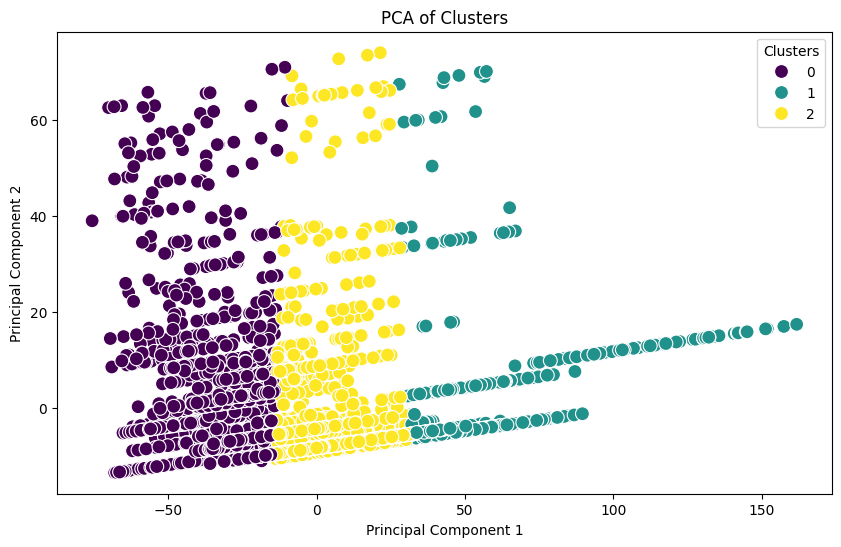

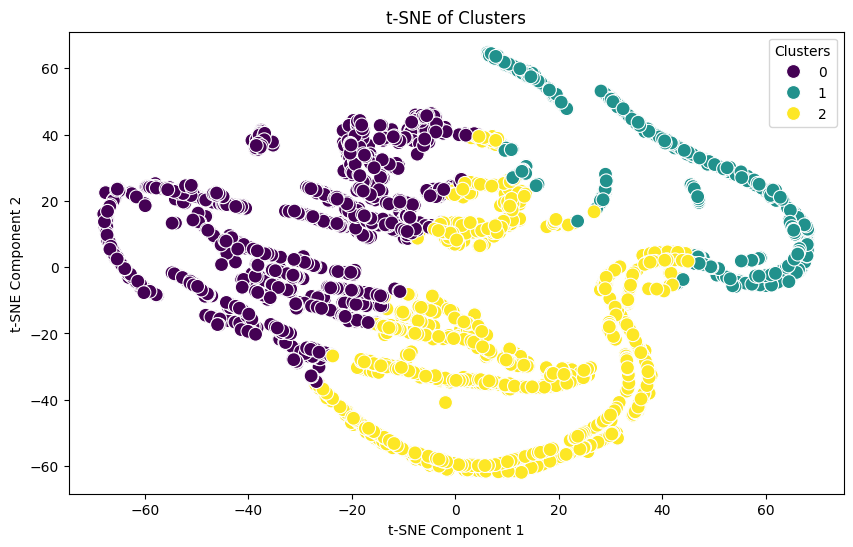

In [72]:


# بارگذاری داده‌ها
data = pd.read_csv('clustering_results.csv')  # مسیر فایل خروجی فاز 3

# نمایش نام ستون‌ها
print("نام ستون‌ها:")
print(data.columns)

# حذف ستون‌های غیرضروری (در صورت وجود)
X = data.drop(columns=['class', 'filename', 'label'], errors='ignore')  # حذف ستون‌های غیرضروری

# خوشه‌بندی با KMeans (تعداد خوشه‌ها بر اساس داده‌های قبلی تنظیم شود)
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X)

# کاهش ابعاد با PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# تجسم خوشه‌ها با PCA
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=clusters, palette='viridis', s=100)
plt.title('PCA of Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Clusters')
plt.show()

# کاهش ابعاد با t-SNE به 2 بعد برای رسم
tsne = TSNE(n_components=2, perplexity=30, max_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(X)

# رسم خوشه‌ها با t-SNE
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=clusters, palette='viridis', s=100)
plt.title('t-SNE of Clusters')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Clusters')
plt.show()


# فاز پنج


In [73]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import precision_score, recall_score, f1_score, silhouette_score

In [74]:


# بارگذاری داده‌ها (خروجی فاز 3 یا 4)
data = pd.read_csv('clustering_results.csv')

# نمایش نام ستون‌ها
print("نام ستون‌ها:")
print(data.columns.tolist())

# حذف ستون‌های غیرضروری برای خوشه‌بندی
X = data.drop(columns=['filename', 'class'], errors='ignore')

# تبدیل برچسب‌های واقعی به عددی (برای مقایسه)
label_encoder = LabelEncoder()
true_labels = label_encoder.fit_transform(data['class'])

# خوشه‌بندی با KMeans (تعداد خوشه‌ها باید متناسب با داده‌های شما باشد)
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X)

# محاسبه معیارهای ارزیابی
precision = precision_score(true_labels, clusters, average='weighted', zero_division=0)
recall = recall_score(true_labels, clusters, average='weighted', zero_division=0)
f1 = f1_score(true_labels, clusters, average='weighted', zero_division=0)
silhouette = silhouette_score(X, clusters)

# نمایش نتایج
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Silhouette Score: {silhouette:.4f}')

# تحلیل تفاوت اعداد خروجی
print("\nتحلیل تفاوت اعداد خروجی:")
print("Precision نشان‌دهنده درصد نمونه‌های مثبت پیش‌بینی‌شده است که واقعاً مثبت هستند.")
print("Recall نشان‌دهنده درصد نمونه‌های مثبت واقعی است که به درستی شناسایی شده‌اند.")
print("F1 Score میانگین هارمونیک precision و recall است که به ما کمک می‌کند تعادل بین این دو را مشاهده کنیم.")
print("Silhouette Score کیفیت خوشه‌ها را نشان می‌دهد و نشان‌دهنده فاصله بین خوشه‌ها است.")


نام ستون‌ها:
['class', 'filename', 'lbp_mean', 'ratio_rg', 'mean_g', 'ratio_gb', 'edge_mean', 'kmeans_cluster', 'dbscan_cluster', 'agg_cluster', 'meanshift_cluster']
Precision: 0.1545
Recall: 0.2475
F1 Score: 0.1849
Silhouette Score: 0.4340

تحلیل تفاوت اعداد خروجی:
Precision نشان‌دهنده درصد نمونه‌های مثبت پیش‌بینی‌شده است که واقعاً مثبت هستند.
Recall نشان‌دهنده درصد نمونه‌های مثبت واقعی است که به درستی شناسایی شده‌اند.
F1 Score میانگین هارمونیک precision و recall است که به ما کمک می‌کند تعادل بین این دو را مشاهده کنیم.
Silhouette Score کیفیت خوشه‌ها را نشان می‌دهد و نشان‌دهنده فاصله بین خوشه‌ها است.


# فاز شیش


In [89]:
import os
import cv2
import shutil
import joblib
import numpy as np
import pandas as pd
from skimage.color import rgb2gray
from skimage.feature import local_binary_pattern
from skimage.transform import resize
from sklearn.preprocessing import StandardScaler

In [90]:


# مسیرها
test_dir = 'test'
test_csv = 'test_data.csv'
output_csv = 'test_predictions_phase6.csv'
output_dir = 'phase6_output'
kmeans_model_path = 'best_kmeans_model.joblib'
selected_features_path = 'selected_features_15.csv'
scaler_path = 'scaler.joblib'

# پارامترهای LBP
radius = 1
n_points = 8 * radius

# تابع استخراج ویژگی از تصویر
def extract_features(image):
    image = resize(image, (128, 128), anti_aliasing=True)
    R, G, B = image[:, :, 0], image[:, :, 1], image[:, :, 2]

    mean_r, mean_g, mean_b = np.mean(R), np.mean(G), np.mean(B)
    var_r, var_g, var_b = np.var(R), np.var(G), np.var(B)
    std_r, std_g, std_b = np.std(R), np.std(G), np.std(B)
    ratio_rg = mean_r / (mean_g + 1e-5)
    ratio_gb = mean_g / (mean_b + 1e-5)
    ratio_rb = mean_r / (mean_b + 1e-5)

    gray_image = rgb2gray(image)
    lbp = local_binary_pattern(gray_image, n_points, radius, method='uniform')
    lbp_mean = np.mean(lbp)

    sobel_x = cv2.Sobel(gray_image, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(gray_image, cv2.CV_64F, 0, 1, ksize=3)
    edge_magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
    edge_mean = np.mean(edge_magnitude)

    return [
        mean_r, mean_g, mean_b,
        var_r, var_g, var_b,
        std_r, std_g, std_b,
        ratio_rg, ratio_gb, ratio_rb,
        lbp_mean, edge_mean
    ]

# مرحله 1: استخراج ویژگی اگر فایل CSV وجود ندارد
if not os.path.exists(test_csv):
    test_data = []
    for class_folder in os.listdir(test_dir):
        class_path = os.path.join(test_dir, class_folder)
        if os.path.isdir(class_path):
            for fname in os.listdir(class_path):
                fpath = os.path.join(class_path, fname)
                img = cv2.imread(fpath)
                if img is None:
                    continue
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                features = extract_features(img)
                test_data.append({
                    'class': class_folder,
                    'filename': fpath,
                    'mean_r': features[0],
                    'mean_g': features[1],
                    'mean_b': features[2],
                    'var_r': features[3],
                    'var_g': features[4],
                    'var_b': features[5],
                    'std_r': features[6],
                    'std_g': features[7],
                    'std_b': features[8],
                    'ratio_rg': features[9],
                    'ratio_gb': features[10],
                    'ratio_rb': features[11],
                    'lbp_mean': features[12],
                    'edge_mean': features[13]
                })
    test_df = pd.DataFrame(test_data)
    test_df.to_csv(test_csv, index=False)
    print(f"✅ فایل '{test_csv}' ساخته شد.")
else:
    test_df = pd.read_csv(test_csv)
    print(f"📄 فایل '{test_csv}' بارگذاری شد.")

# مرحله 2: بارگذاری ویژگی‌های انتخاب‌شده
selected_df = pd.read_csv(selected_features_path)
selected_features = [col for col in selected_df.columns if col not in ['class', 'filename']]

# مرحله 3: نرمال‌سازی تست
X_test = test_df[selected_features]
scaler = joblib.load(scaler_path)
X_test_scaled = scaler.transform(X_test)

# مرحله 4: بارگذاری مدل و پیش‌بینی
kmeans = joblib.load(kmeans_model_path)
test_df['predicted_cluster'] = kmeans.predict(X_test_scaled)

# مرحله 5: ذخیره فایل CSV خروجی
test_df[['class', 'filename'] + selected_features + ['predicted_cluster']].to_csv(output_csv, index=False)
print(f"✅ نتایج در '{output_csv}' ذخیره شد.")

# مرحله 6: ذخیره تمام تصاویر تست در پوشه‌هایی به نام کلاس واقعی (مثلاً 'جنگل')
os.makedirs(output_dir, exist_ok=True)

for i, row in test_df.iterrows():
    img_path = row['filename']
    class_name = row['class']
    class_output_dir = os.path.join(output_dir, class_name)
    os.makedirs(class_output_dir, exist_ok=True)

    base_name = os.path.basename(img_path)
    output_path = os.path.join(class_output_dir, base_name)

    shutil.copy(img_path, output_path)

print("📁 تمام تصاویر طبق کلاس واقعی در 'phase6_output' ذخیره شدند.")
print("✅ فاز ۶ با موفقیت پایان یافت.")


📄 فایل 'test_data.csv' بارگذاری شد.
✅ نتایج در 'test_predictions_phase6.csv' ذخیره شد.
📁 تمام تصاویر طبق کلاس واقعی در 'phase6_output' ذخیره شدند.
✅ فاز ۶ با موفقیت پایان یافت.
